In [1]:
import numpy as np
import torch
import copy
import math
from torch.distributions import Categorical
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse

import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd 
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import os
import datetime
from shutil import copyfile
import sys
import traci
import random
import timeit

from generator import TrafficGenerator
from memory import Memory     ## Prority Experience Memory 
from visualization import Visualization

from utils import import_train_configuration,set_sumo, set_train_path,get_model_path

import warnings
warnings.filterwarnings('ignore')

# Actions

In [2]:
# phase codes based on SUMO environment.net.xml 
PHASE_NS_GREEN = 0  # action 0 for Variable Order
PHASE_NS_YELLOW = 1
PHASE_NSL_GREEN = 2  # action 1 for Variable Order
PHASE_NSL_YELLOW = 3
PHASE_EW_GREEN = 4  # action 2 for Variable Order
PHASE_EW_YELLOW = 5
PHASE_EWL_GREEN = 6  # action 3 for Variable Order
PHASE_EWL_YELLOW = 7

# New phases added
PHASE_N_SL_GREEN = 8
PHASE_N_SL_YELLOW= 9
PHASE_E_SL_GREEN = 10
PHASE_E_SL_YELLOW= 11
PHASE_S_SL_GREEN = 12
PHASE_S_SL_YELLOW= 13
PHASE_W_SL_GREEN = 14
PHASE_W_SL_YELLOW= 15

# State

In [3]:
def _get_state():
    """
    Retrieve the state of the intersection from sumo, in the form of cell occupancy
    """
    state = np.zeros((3, 209, 206))   ## kind of like an RGB image
    lane = ["N2TL_0","N2TL_1","N2TL_2","E2TL_0","E2TL_1","E2TL_2","E2TL_3","S2TL_0","S2TL_1","S2TL_2","W2TL_0","W2TL_1","W2TL_2","W2TL_3"]
    # N, E, S, W
    #           N
    #   W               E
    #           S    
    car_list = traci.vehicle.getIDList()

    for car_id in car_list:
        lane_pos = traci.vehicle.getLanePosition(car_id)
        car_speed = traci.vehicle.getSpeed(car_id)
        lane_id = traci.vehicle.getLaneID(car_id)

        if 'N2TL' in lane_id:            
            x = 100 + int(lane_id[-1])
            y = int(lane_pos//7.5)
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 # normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/300.0 #waitingTime
            
        if 'E2TL' in lane_id:
            x = 205 - int(lane_pos//7.5)
            y = 99 + 1 + int(lane_id[-1])
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/300.0 #waitingTime

        if 'S2TL' in lane_id:
            x = 100 + 3 + int(lane_id[-1])
            y = 207 + 1 - int(lane_pos//7.5)
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/300.0 #waitingTime

        if 'W2TL' in lane_id:
            x = int(lane_pos//7.5)
            y = 99 + 1 + 4 + 3 - int(lane_id[-1])
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed /50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/300.0 #waitingTime

    #Return a partial view of the state
    return state[:, state.shape[1]//2 - 24: state.shape[1]//2 + 24, state.shape[2]//2 - 23: state.shape[2]//2 + 23]#.tolist()

# Environment

In [4]:
#agent,trafficGen,sumo_cmd,opt.max_e_steps,green_duration,yellow_duration,opt.state_dim,opt.action_dim, False
class Simulation:
    def __init__(self, Agent, TrafficGen, sumo_cmd, max_steps, green_duration, yellow_duration, num_states, num_actions, mode, device):
        self._Agent = Agent
        self._Actor = Agent.actor
        self._Critic= Agent.critic
        self._TrafficGen = TrafficGen
        self._step = 0
        self._sumo_cmd = sumo_cmd
        self._max_steps = max_steps 
        self._green_duration = green_duration
        self._yellow_duration = yellow_duration
        self._num_states = num_states
        self._num_actions = num_actions
        self._reward_store = []
        self._speed_store = []
        self._cumulative_wait_store = []
        self._avg_queue_length_store = []
        self._eval = mode
        self.dvc = device

    def run(self, episode):
        """
        Runs an episode of simulation, then starts a training session
        """
        self.training = False
        start_time = timeit.default_timer()

        # first, generate the route file for this simulation and set up sumo
        if not self._eval:
            self._TrafficGen.generate_routefile(seed=episode)
        else:
            self._TrafficGen.generate_routefile(seed=500+episode)
        traci.start(self._sumo_cmd)
        print("Simulating...")

        # inits
        self._step = 0
        self._waiting_times = {}
        self._sum_neg_reward = 0
        self._sum_queue_length = 0
        self._sum_waiting_time = 0
        duration = [0,0,0,0,0,0,0,0]
        self._sum_speed = 0
        reward = 0
        re = 0
        current_phase = 0
        self.reward = 0
        done = 0
        old_action = 0
        last_queue = 0
        self._simulate(50)  ## Warm Environment
        h_out = (torch.zeros([1, 1, 128], dtype=torch.float).to(self.dvc), torch.zeros([1, 1, 128], dtype=torch.float).to(self.dvc))

        while self._step < self._max_steps:
            
            # get current state of the intersection
            current_state = _get_state()

            # calculate reward of previous action: 
            # waiting time = seconds waited by a car since the spawn in the environment, cumulated for every car in incoming lanes
            current_total_wait = self._collect_waiting_times()    

            #self._sum_waiting_time += current_total_wait
            # Types of reward
            # Waiting times
            # Queues
            # Avg speed            
            ## Your Reward Function
            ### Positive reward ---> when the queue length is reduced by the previously chosen action ----> delta < 0 ---> previous - curr > 0
            ### Negative reward ---> when the queue length is increased by the previously chosen action ----> delta > 0 ---> previous - curr < 0
            
            # Current light phase
            current_phase = int(traci.trafficlight.getPhase("TL")/2)
            # Chosen action
            h_in = h_out
            action, logprob_a, h_out = self._choose_action(current_state, h_in, self._eval)            
            last_queue = self._get_queue_length()

            # saving the data into the memory                
            # if the chosen phase is different from the last phase, activate the yellow phase
            if self._step != 0 and old_action != action:# and i == 0:
                self._set_yellow_phase(current_phase)
                self._simulate(self._yellow_duration)
                duration[action] = self._green_duration
                #last_queue = self._get_queue_length()
                # Perform chosen action on environment
                self._set_green_phase(action)
                self._simulate(self._green_duration)    
            elif self._step != 0 and old_action == action:
                #last_queue = self._get_queue_length()
                # Perform chosen action on environment
                self._set_green_phase(action)
                self._simulate(7)
            # Capture next state information
            reward = -self._get_queue_length() #+ last_queue
            if self._step != 0:
                next_state = _get_state()
                if self._step < self._max_steps - self._green_duration - self._yellow_duration:
                    done = 0
                else:
                    done = 1
                if not self._eval and agent.idx < agent.T_horizon:
                    cat_hin = torch.cat((h_in[0], h_in[1]), dim=1).cpu()
                    cat_hout = torch.cat((h_out[0], h_out[1]), dim=1).cpu()
                    self._Agent.put_data(current_state, action, reward, next_state, logprob_a, cat_hin.numpy(), cat_hout.numpy(), done, done)            
            # saving only the meaningful reward to better see if the agent is behaving correctly
            #if reward < 0:
            self._sum_neg_reward += reward
            re += 1
            old_action = action
        
        self.reward = self._sum_neg_reward/re
                
        print("Total Queue:",self._sum_queue_length, "  ", "Average Reward:", self.reward)
        print("Average Waiting time: {:.4f}".format(self._sum_waiting_time/1000))
        print("Average Speed: {:.4f}".format(self._sum_speed/self._max_steps))
        print("Average Queue length: {:.4f}".format(self._sum_queue_length / self._max_steps))
        #      "    Average Waiting Time:", self_sum_waiting_time/self._max_steps)

        self._save_episode_stats()
        #print("Total Reward:", self._sum_neg_reward)
        traci.close()
        simulation_time = round(timeit.default_timer() - start_time, 1)
        if not self._eval: 
            return simulation_time
        else:
            return simulation_time, self.reward

    def _simulate(self, steps_todo):
        """
        Execute steps in sumo while gathering statistics
        """
        if (self._step + steps_todo) >= self._max_steps:  # do not do more steps than the maximum allowed number of steps
            steps_todo = self._max_steps - self._step

        while steps_todo > 0:
            traci.simulationStep()  # simulate 1 step in sumo
            self._step += 1 # update the step counter
            steps_todo -= 1
            queue_length = self._get_queue_length()
            self._sum_queue_length += queue_length
            self._sum_waiting_time += queue_length # 1 step while wating in queue means 1 second waited, for each car, therefore queue_lenght == waited_seconds
            speed = self._get_speed()
            self._sum_speed += speed
        
    def _collect_waiting_times(self):            # For reward 
        """
        Retrieve the waiting time of every car in the incoming roads
        """
        incoming_roads = ["E2TL", "N2TL", "W2TL", "S2TL"]
        car_list = traci.vehicle.getIDList()
        self._waiting_times = {}
        for car_id in car_list:
            wait_time = traci.vehicle.getAccumulatedWaitingTime(car_id)
            road_id = traci.vehicle.getRoadID(car_id)  # get the road id where the car is located
            if road_id in incoming_roads:  # consider only the waiting times of cars in incoming roads
                self._waiting_times[car_id] = wait_time 
            else:
                if car_id in self._waiting_times: # a car that was tracked has cleared the intersection
                    del self._waiting_times[car_id] 
                
        if len(self._waiting_times) == 0: 
            total_waiting_time = 0
        else: 
            total_waiting_time = sum(self._waiting_times.values())/len(self._waiting_times)
        return total_waiting_time 

    def _choose_action(self, state, h_in, deterministic):
        state = torch.from_numpy(state).float().to(self.dvc)
        #print(state.shape)
        with torch.no_grad():
            pi, h_out = self._Actor.pi(state, h_in, softmax_dim=-1)
            pi = pi.view(-1, 8) #Adjusting dimensions after LSTM layer
            #print(pi)
            #print(pi.shape)
            if deterministic:
                action = torch.argmax(pi).item()
                return action, h_out, None
            else:
                m = Categorical(pi)
                #print(m)
                action = m.sample()
                #pi_a = pi[0,action].item()
                action_logprob = m.log_prob(action)
                return action.item(), action_logprob.item(), h_out

    def _set_yellow_phase(self, old_action):
        """
        Activate the correct yellow light combination in sumo
        """
        yellow_phase_code = old_action * 2 + 1 # obtain the yellow phase code, based on the old action (ref on environment.net.xml)
        traci.trafficlight.setPhase("TL", yellow_phase_code)

    def _set_green_phase(self, action_number):   ## For Variable Order Method 
        """
        Activate the correct green light combination in sumo
        """
        if action_number == 0:
            traci.trafficlight.setPhase("TL", PHASE_NS_GREEN)
        elif action_number == 1:
            traci.trafficlight.setPhase("TL", PHASE_NSL_GREEN)
        elif action_number == 2:
            traci.trafficlight.setPhase("TL", PHASE_EW_GREEN)
        elif action_number == 3:
            traci.trafficlight.setPhase("TL", PHASE_EWL_GREEN)
        elif action_number == 4:
            traci.trafficlight.setPhase('TL', PHASE_N_SL_GREEN)
        elif action_number == 5:
            traci.trafficlight.setPhase('TL', PHASE_E_SL_GREEN)
        elif action_number == 6:
            traci.trafficlight.setPhase('TL', PHASE_S_SL_GREEN)
        elif action_number == 7:
            traci.trafficlight.setPhase('TL', PHASE_W_SL_GREEN)

        # Add New phases (North Straight and Left, South Straight and Left, West Straight and Left, East Straight and Left)

    def _get_green(self,current_phase):       ## For Finetuning Method 
        if current_phase == 0:
            green = Duration_NS
        elif current_phase == 1:
            green = Duration_NSL
        elif current_phase == 2:
            green = Duration_EW
        elif current_phase == 3: 
            green = Duration_EWL
        else:
            green = Duration_N_SL
        
        return green

    def _get_queue_length(self):          # For evaluation 
        """
        Retrieve the number of cars with speed = 0 in every incoming lane
        """
        halt_N = traci.edge.getLastStepHaltingNumber("N2TL")
        halt_S = traci.edge.getLastStepHaltingNumber("S2TL")
        halt_E = traci.edge.getLastStepHaltingNumber("E2TL")
        halt_W = traci.edge.getLastStepHaltingNumber("W2TL")
        queue_length = halt_N + halt_S + halt_E + halt_W
        return queue_length
    
    def _get_speed(self):                  # For evaluation 
        total_speed = 0
        car_list = traci.vehicle.getIDList()
        for car_id in car_list:
            car_speed = traci.vehicle.getSpeed(car_id)
            total_speed +=car_speed
        if len(car_list) == 0: 
            s = 0
        else: 
            s = total_speed/len(car_list)
        return s
            
    def _save_episode_stats(self):
        """
        Save the stats of the episode to plot the graphs at the end of the session
        """
        self._reward_store.append(self.reward)  # how much negative reward in this episode
        self._speed_store.append(self._sum_speed / self._max_steps)
        self._cumulative_wait_store.append(self._sum_waiting_time)  # total number of seconds waited by cars in this episode
        self._avg_queue_length_store.append(self._sum_queue_length / self._max_steps)  # average number of queued cars per step, in this episode
    
    @property
    def reward_store(self):
        return self._reward_store

    @property
    def speed_store(self):
        return self._speed_store
    
    @property
    def cumulative_wait_store(self):
        return self._cumulative_wait_store

    @property
    def avg_queue_length_store(self):
        return self._avg_queue_length_store

# Actor-Critic Networks

In [5]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight)
        nn.init.zeros_(m.bias)
'''elif isinstance(m, nn.LSTM):
for name, param in m.named_parameters():
if 'weight_ih' in name:
nn.init.orthogonal_(param.data)
elif 'weight_hh' in name:
nn.init.orthogonal_(param.data)
elif 'bias' in name:
nn.init.zeros_(param.data)
#n = param.size(0)
#param.data[n//4:n//2].fill_(1.0)'''

class Actor(nn.Module):
    def __init__(self, action_dim):
        super(Actor, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (5,5), (1,1), padding='same')
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(16, 32, (3,3), (1,1), padding='same')
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.lstm  = nn.LSTM(32*11*12, 128, 1, batch_first=True)
        self.l1 = nn.Linear(128, 64)
        self.l2 = nn.Linear(64, 32)
        self.l3 = nn.Linear(32, action_dim)        

    def forward(self, state, hidden):
        n = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(state))))))
        n = n.view(-1, 1, 32*11*12) #n.reshape(-1, 32*11*12)
        n, lstm_hidden = self.lstm(n, hidden) 
        n = torch.tanh(self.l1(n))
        n = torch.tanh(self.l2(n))
        return n, lstm_hidden

    def pi(self, state, hidden, softmax_dim = -1):
        n, lstm_hidden = self.forward(state, hidden)
        prob = F.softmax(self.l3(n), dim=softmax_dim)
        return prob, lstm_hidden

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (5,5), (1,1), padding='same')
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(16, 32, (3,3), (1,1), padding='same')
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.lstm  = nn.LSTM(32*11*12, 128, 1, batch_first=True)
        self.C1 = nn.Linear(128, 64)
        self.C2 = nn.Linear(64, 32)
        self.C3 = nn.Linear(32, 1)

    def forward(self, state, hidden):
        v = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(state))))))
        v = v.view(-1, 1, 32*12*11)#reshape(-1, 32*12*11)
        v, lstm_hidden = self.lstm(v, hidden)
        v = torch.relu(self.C1(v))
        v = torch.relu(self.C2(v))
        v = self.C3(v)
        return v

# Policy Evaluation

In [6]:
import random
# Need to update to SUMO environment
def evaluate_policy(env, agent, turns = 3):
    total_scores = 0
    total_time = 0
    for j in range(turns):
        episode = random.randint(0, 2**31 - 1)
        simulation_time, reward = env.run(episode)
        total_scores += reward
        total_time += simulation_time
    return int(total_scores/turns), total_time

In [7]:
import scipy
# Function extracted from Hybrid-PPO SUMO implementation in https://github.com/Metro1998/hppo-in-traffic-signal-control/blob/main/src/hppo/HPPO.py
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

# PPO Agent

In [8]:
# Need to update to SUMO environment
class PPO_agent():
    def __init__(self, **kwargs):
        # Init hyperparameters for PPO agent, just like "self.gamma = opt.gamma, self.lambd = opt.lambd, ..."
        self.__dict__.update(kwargs)

        '''Build Actor and Critic'''
        self.actor = Actor(self.action_dim).to(self.dvc)
        self.actor.apply(weight_init)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic = Critic().to(self.dvc)
        self.critic.apply(weight_init)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        '''Build Trajectory holder'''
        self.s_hoder = np.zeros(([self.T_horizon] + self.state_dim), dtype=np.float32) #observation
        self.a_hoder = np.zeros((self.T_horizon, 1), dtype=np.int64) #action
        self.r_hoder = np.zeros((self.T_horizon, 1), dtype=np.float32) #reward
        self.s_next_hoder = np.zeros(([self.T_horizon] + self.state_dim), dtype=np.float32) #
        self.val_hoder = np.zeros((self.T_horizon,1), dtype=np.float32) #expected value
        self.logprob_a_hoder = np.zeros((self.T_horizon, 1), dtype=np.float32) #logprob_action
        self.hin_hoder  = np.zeros((self.T_horizon,2,128), dtype=np.float32)
        self.hout_hoder = np.zeros((self.T_horizon,2,128), dtype=np.float32)
        self.done_hoder = np.zeros((self.T_horizon, 1), dtype=np.bool_)
        self.dw_hoder = np.zeros((self.T_horizon, 1), dtype=np.bool_)
        self.idx = 0

        '''Training history'''
        self.actor_losses = []
        self.critic_losses= []
        self.entropies = []

    def train(self):
        start_time = timeit.default_timer()
        self.entropy_coef *= self.entropy_coef_decay #exploring decay
        '''Prepare PyTorch data from Numpy data'''
        s = torch.from_numpy(self.s_hoder).to(self.dvc)
        a = torch.from_numpy(self.a_hoder).to(self.dvc)
        r = torch.from_numpy(self.r_hoder).to(self.dvc)
        s_next = torch.from_numpy(self.s_next_hoder).to(self.dvc)
        old_prob_a = torch.from_numpy(self.logprob_a_hoder).to(self.dvc)
        
        h1_in, h2_in = torch.from_numpy(self.hin_hoder[:, 0, :]), torch.from_numpy(self.hin_hoder[:, 1, :])
        first_hidden = (h1_in.view(1,256,-1).to(self.dvc), h2_in.view(1,256,-1).to(self.dvc))
        h1_out, h2_out= torch.from_numpy(self.hout_hoder[:, 0, :]), torch.from_numpy(self.hout_hoder[:, 1, :])
        second_hidden = (h1_out.view(1,256,-1).to(self.dvc), h2_out.view(1,256,-1).to(self.dvc))
        
        done = torch.from_numpy(self.done_hoder).to(self.dvc)
        dw = torch.from_numpy(self.dw_hoder).to(self.dvc)

        ''' Use TD+GAE+LongTrajectory to compute Advantage and TD target'''
        with torch.no_grad():
            vs = self.critic(s, first_hidden).squeeze(1)
            vs_ = self.critic(s_next, second_hidden).squeeze(1)

            '''GAE calculation'''
            deltas = r + self.gamma*vs_*(~dw) - vs #self.gamma * vs_ * (~dw)
            deltas = deltas.cpu().flatten().numpy()            
            
            adv = [0]

            '''done for GAE'''
            for dlt, done in zip(deltas[::-1], done.cpu().flatten().numpy()[::-1]):
                advantage = dlt + self.gamma * self.lambd * adv[-1] * (~done)
                adv.append(advantage)
            adv.reverse()
            #adv = discount_cumsum(deltas, self.gamma * self.lambd)            
            adv = copy.deepcopy(adv[:-1])
            adv = torch.tensor(adv).unsqueeze(1).float().to(self.dvc)

            td_target = adv + vs
            if self.adv_normalization:
                adv = (adv - adv.mean()) / ((adv.std() + 1e-4))  #sometimes helps

        """PPO update"""
        #Slice long trajectopy into short trajectory and perform mini-batch PPO update
        optim_iter_num = int(math.ceil(s.shape[0] / self.batch_size))

        for _ in range(self.K_epochs):
            #Shuffle the trajectory, Good for training
            perm = np.arange(s.shape[0])
            np.random.shuffle(perm)
            perm = torch.LongTensor(perm).to(self.dvc)
            s, a, td_target, adv, old_prob_a, f1, f2 = \
                s[perm].clone(), a[perm].clone(), td_target[perm].clone(), adv[perm].clone(), old_prob_a[perm].clone(), first_hidden[0][:, perm, :].clone(), first_hidden[1][:, perm, :].clone()
            '''mini-batch PPO update'''
            for i in range(optim_iter_num):
                index = slice(i * self.batch_size, min((i + 1) * self.batch_size, s.shape[0]))

                self.actor_optimizer.zero_grad()                
                '''actor update'''
                prob, _ = self.actor.pi(s[index], (f1[:, index, :], f2[:, index, :]), softmax_dim=-1)
                prob = prob.view(-1,8)
                entropy = Categorical(prob).entropy().sum(0, keepdim=True)
                prob_a = prob.gather(1, a[index])
                ratio = torch.exp(torch.log(prob_a) - old_prob_a[index])  # a/b == exp(log(a)-log(b))

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1 - self.clip_rate, 1 + self.clip_rate) * adv[index]
                a_loss = -torch.min(surr1, surr2) - self.entropy_coef * entropy.view(-1,1)

                a_loss.mean().backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), norm_type=2, max_norm=40)
                self.actor_optimizer.step()

                self.critic_optimizer.zero_grad()
                '''critic update'''
                c_loss = (self.critic(s[index], (f1[:, index, :], f2[:, index, :])).view(-1,1) - td_target[index]).pow(2).mean()
                for name, param in self.critic.named_parameters():
                    if 'weight' in name:
                        c_loss += param.pow(2).sum() * self.l2_reg
                
                c_loss.backward()
                self.critic_optimizer.step()
        simulation_time = round(timeit.default_timer() - start_time, 1)
        return simulation_time, a_loss.mean(), c_loss, entropy.mean()

    def put_data(self, s, a, r, s_next, logprob_a, h_in, h_out, done, dw):
        self.s_hoder[self.idx] = s
        self.a_hoder[self.idx] = a
        self.r_hoder[self.idx] = r
        self.s_next_hoder[self.idx] = s_next
        self.logprob_a_hoder[self.idx] = logprob_a
        self.hin_hoder[self.idx] = h_in
        self.hout_hoder[self.idx]= h_out
        self.done_hoder[self.idx] = done
        self.dw_hoder[self.idx] = dw
        self.idx+=1

    def save(self, episode):
        torch.save(self.critic.state_dict(), "./models/ppo_critic{}.pth".format(episode))
        torch.save(self.actor.state_dict(), "./models/ppo_actor{}.pth".format(episode))

    def load(self, episode):
        self.critic.load_state_dict(torch.load("./models/ppo_critic{}.pth".format(episode)))
        self.actor.load_state_dict(torch.load("./models/ppo_actor{}.pth".format(episode)))

In [9]:
class PPOOptions:
    def __init__(self, dvc: str = 'cuda', EnvIndex: int = 0, render: bool = False, seed: int = 209, T_horizon: int = 2048,
                 Max_train_steps: int = 5e7, eval_interval: int = 5e3, gamma: float = 0.99, lambd: float = 0.95, clip_rate: float = 0.2,
                 K_epochs: int = 10, net_width: int = 64, lr: float = 1e-4, l2_reg: float = 0, batch_size: int = 64, entropy_coef: float = 0,
                 entropy_coef_decay: float = 0.99, adv_normalization: bool = False):

        self.dvc = dvc
        self.EnvIdex = EnvIndex
        self.render = render
        self.seed = seed
        self.T_horizon = T_horizon
        self.Max_train_steps = Max_train_steps
        self.eval_interval = eval_interval
        self.gamma = gamma
        self.lambd = lambd
        self.clip_rate = clip_rate
        self.K_epochs = K_epochs
        self.net_width = net_width
        self.lr = lr
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        self.entropy_coef_decay = entropy_coef_decay
        self.adv_normalization = adv_normalization

In [10]:
model_to_test = 1   # load model
if __name__ == "__main__":
    config = import_train_configuration(config_file='training_settings.ini')
    sumo_cmd = set_sumo(False, config['sumocfg_file_name'], 3600)
    path = set_train_path(config['models_path_name'])
    model_path = get_model_path(config['models_path_name'], model_to_test)
    opt = PPOOptions(entropy_coef = 0.1, T_horizon = 256, eval_interval= 500, K_epochs=15, adv_normalization = True, batch_size=16, lr = 1e-5, l2_reg=0.1)
    opt.dvc = torch.device(opt.dvc) # from str to torch.device
    opt.state_dim = [3,48,46]
    opt.action_dim = 8
    opt.max_e_steps = 3600
    n_cars_generated = 1000
    green_duration = 7
    yellow_duration = 6
    total_episodes = 400

    agent = PPO_agent(**vars(opt)) #DRL_Model(num_layers, width_layers, batch_size, learning_rate, input_dim=num_states, output_dim=num_actions,tau=1,num_atoms=num_atoms)

    trafficGen = TrafficGenerator(opt.max_e_steps, n_cars_generated)

    visualization = Visualization(path, dpi=96)
        
    simulation = Simulation(agent,trafficGen,sumo_cmd,opt.max_e_steps,green_duration,yellow_duration,opt.state_dim,opt.action_dim, False, opt.dvc)

    evaluation = Simulation(agent,trafficGen,sumo_cmd,opt.max_e_steps,green_duration,yellow_duration,opt.state_dim,opt.action_dim, True, opt.dvc)
  
    episode = 0
    timestamp_start = datetime.datetime.now()
    break
    while episode < total_episodes:
        print('\n----- Episode', str(episode+1), 'of', str(total_episodes))
        print(agent.idx, agent.T_horizon)
        simulation_time = simulation.run(episode)  # run the simulation
        if (agent.idx) % opt.T_horizon == 0:
            training_time, actor_loss, critic_loss, entropy = agent.train()
            agent.critic_losses.append(critic_loss)
            agent.actor_losses.append(actor_loss)
            agent.entropies.append(entropy)
            agent.idx = 0
            print('Simulation time:', simulation_time, 's - Training time:', training_time, 's - Total:', round(simulation_time+training_time, 1), 's')
            print('Actor loss: {:.4f}, Critic loss: {:.4f}'.format(actor_loss, critic_loss))
            print('Entropy: {}'.format(entropy))
        else:
            print('Simulation time:', simulation_time, 's')
        '''Record & log'''
        if (episode+1) % opt.eval_interval == 0:
            score, eval_time = evaluate_policy(evaluation, agent, turns=3) # evaluate the policy for 3 times, and get averaged result
            print('Evaluation time:', eval_time, 's', 'Score:', score)
            #if opt.write: writer.add_scalar('ep_r', score, global_step=total_steps)
            #print('EnvName:',EnvName[0],'seed:',env_seed,'steps: {}k'.format(int(total_steps/1000)),'score:', score)        
        episode += 1
        
    print("\n----- Start time:", timestamp_start)
    print("----- End time:", datetime.datetime.now())
    #print("----- Session info saved at:", path)
    #Model.save_model(path)
    #copyfile(src='training_settings.ini', dst=os.path.join(path, 'training_settings.ini'))


----- Episode 1 of 400
0 256
Simulating...
Total Queue: 53496    Average Reward: -15.110344827586207
Average Waiting time: 53.4960
Average Speed: 8.6939
Average Queue length: 14.8600
Simulation time: 37.1 s - Training time: 3.2 s - Total: 40.3 s
Actor loss: -3.1601, Critic loss: 171080.7656
Entropy: 33.21662902832031

----- Episode 2 of 400
0 256
Simulating...
Total Queue: 101291    Average Reward: -28.320557491289197
Average Waiting time: 101.2910
Average Speed: 6.0847
Average Queue length: 28.1364
Simulation time: 46.2 s - Training time: 2.9 s - Total: 49.1 s
Actor loss: -3.1373, Critic loss: 526946.0625
Entropy: 33.213958740234375

----- Episode 3 of 400
0 256
Simulating...
Total Queue: 71848    Average Reward: -20.18402777777778
Average Waiting time: 71.8480
Average Speed: 7.5876
Average Queue length: 19.9578
Simulation time: 40.4 s - Training time: 3.0 s - Total: 43.4 s
Actor loss: -3.1047, Critic loss: 335396.5000
Entropy: 33.195045471191406

----- Episode 4 of 400
0 256
Simulat

In [12]:
model_to_test = '400_LSTM-CNN'
config = import_train_configuration(config_file='training_settings.ini')
#sumo_cmd = set_sumo(False, config['sumocfg_file_name'], 3600)
#path = set_train_path(config['models_path_name'])
model_path = get_model_path(config['models_path_name'], model_to_test)
print(model_path)

opt = PPOOptions(entropy_coef = 0.1, T_horizon = 256, eval_interval= 500, K_epochs=15, adv_normalization = True, batch_size=16, lr = 1e-5, l2_reg=0.1)
opt.dvc = torch.device(opt.dvc) # from str to torch.device
opt.state_dim = [3,48,46]
opt.action_dim = 8
opt.max_e_steps = 3600
n_cars_generated = 1000
green_duration = 7
yellow_duration = 6
total_episodes = 400

agent = PPO_agent(**vars(opt)) #DRL_Model(num_layers, width_layers, batch_size, learning_rate, input_dim=num_states, output_dim=num_actions,tau=1,num_atoms=num_atoms)

agent.load(model_to_test)

trafficGen = TrafficGenerator(opt.max_e_steps, n_cars_generated)

visualization = Visualization('./', dpi=96)
    
sumo_cmd = set_sumo(True, config['sumocfg_file_name'], 3600)
evaluation = Simulation(agent,trafficGen,sumo_cmd,opt.max_e_steps,green_duration,yellow_duration,opt.state_dim,opt.action_dim, True, opt.dvc)
score, eval_time = evaluate_policy(evaluation, agent, turns=10) # evaluate the policy for 3 times, and get averaged result
print('Evaluation time:', eval_time, 's', 'Score:', score)


C:\Users\jazg2\OneDrive\Documents\IA368FF-RL\ProjetoComputacional\TrafficSignalControl_RL\Code\models\model_400_LSTM-CNN\
Simulating...
Total Queue: 52787    Average Reward: -12.652054794520549
Average Waiting time: 52.7870
Average Speed: 7.1887
Average Queue length: 14.6631
Simulating...
Total Queue: 56401    Average Reward: -13.678670360110804
Average Waiting time: 56.4010
Average Speed: 7.4772
Average Queue length: 15.6669
Simulating...
Total Queue: 51586    Average Reward: -12.06868131868132
Average Waiting time: 51.5860
Average Speed: 7.8469
Average Queue length: 14.3294
Simulating...
Total Queue: 56239    Average Reward: -13.14010989010989
Average Waiting time: 56.2390
Average Speed: 7.3260
Average Queue length: 15.6219
Simulating...
Total Queue: 41457    Average Reward: -10.343163538873995
Average Waiting time: 41.4570
Average Speed: 7.2849
Average Queue length: 11.5158
Simulating...
Total Queue: 50234    Average Reward: -11.673024523160763
Average Waiting time: 50.2340
Average 

In [30]:
episode = '400_LSTM-CNN'

torch.save(agent.critic.state_dict(), "./models/ppo_critic{}.pth".format(episode))
torch.save(agent.actor.state_dict(), "./models/ppo_actor{}.pth".format(episode))

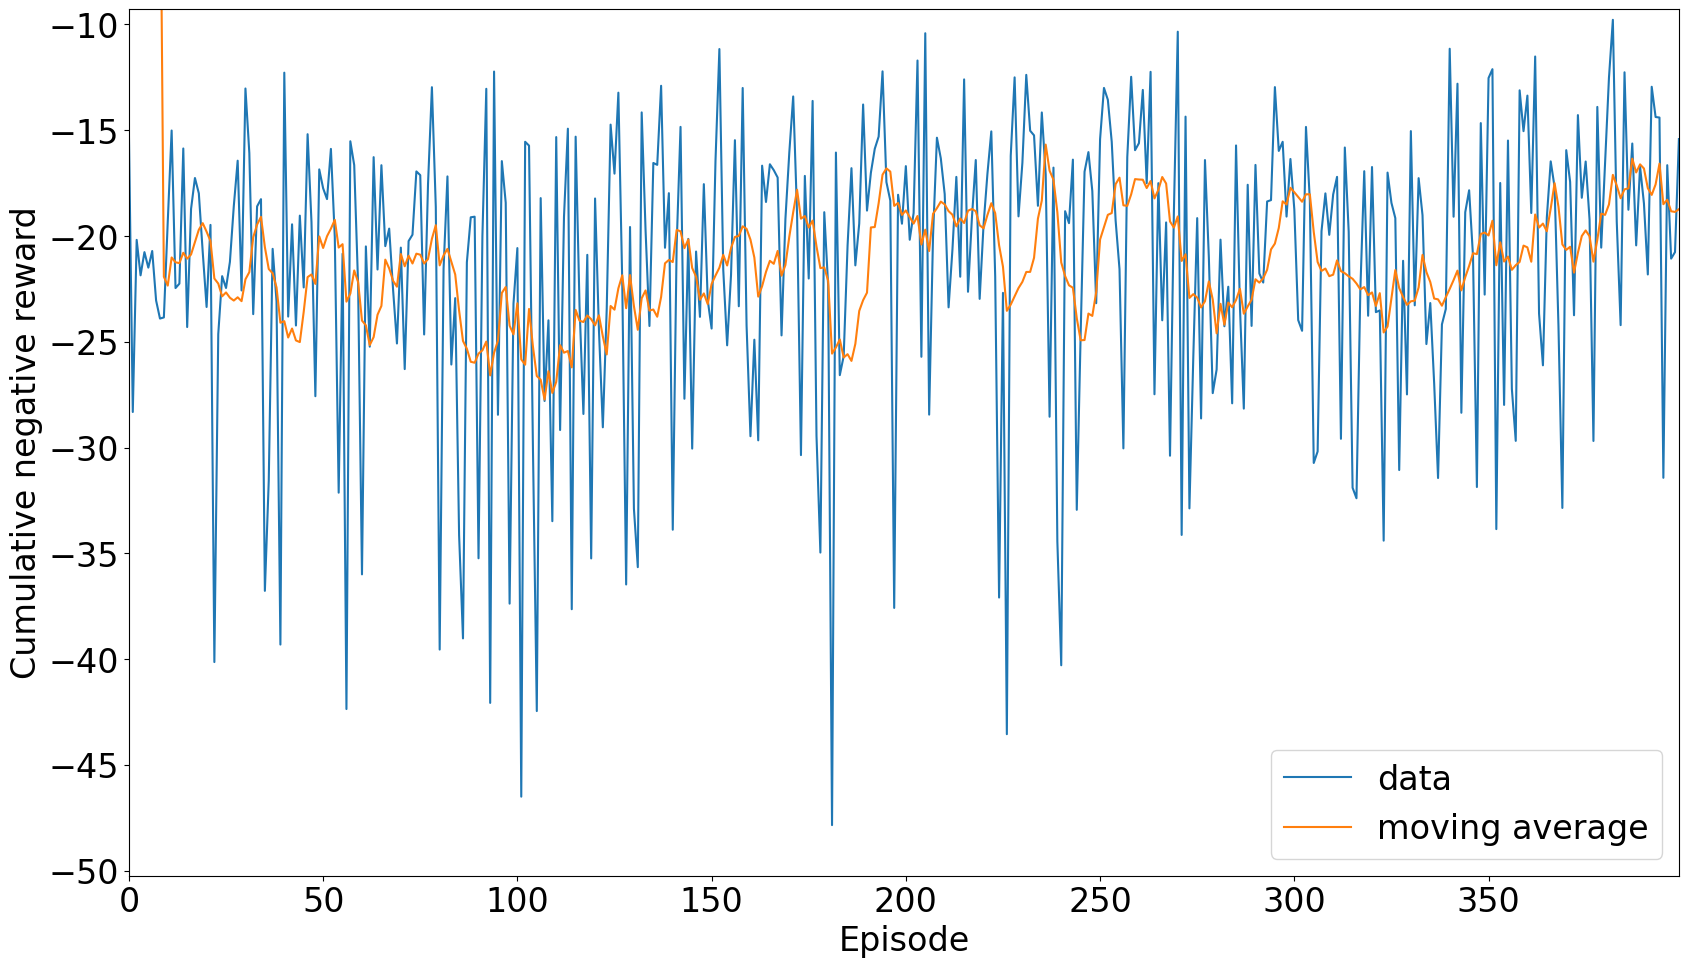

In [11]:
visualization.save_data_and_plot(data=simulation.reward_store, filename='reward', xlabel='Episode', ylabel='Cumulative negative reward')  

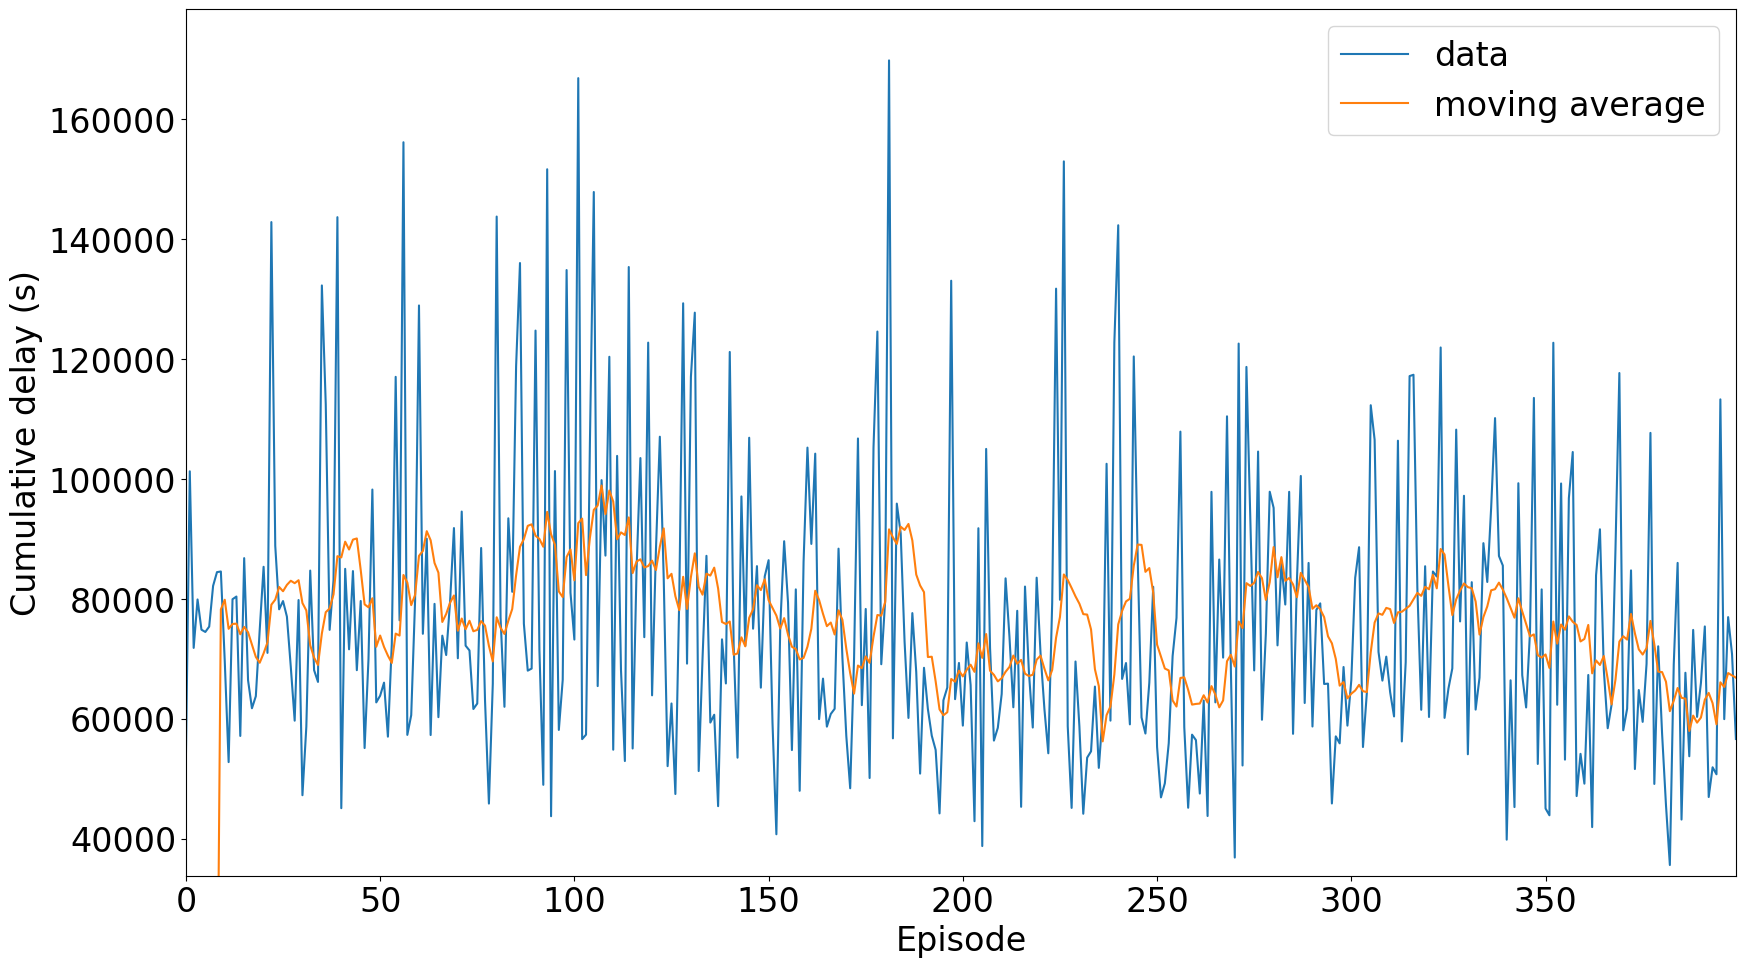

In [12]:
visualization.save_data_and_plot(data=simulation.cumulative_wait_store, filename='delay', xlabel='Episode', ylabel='Cumulative delay (s)')

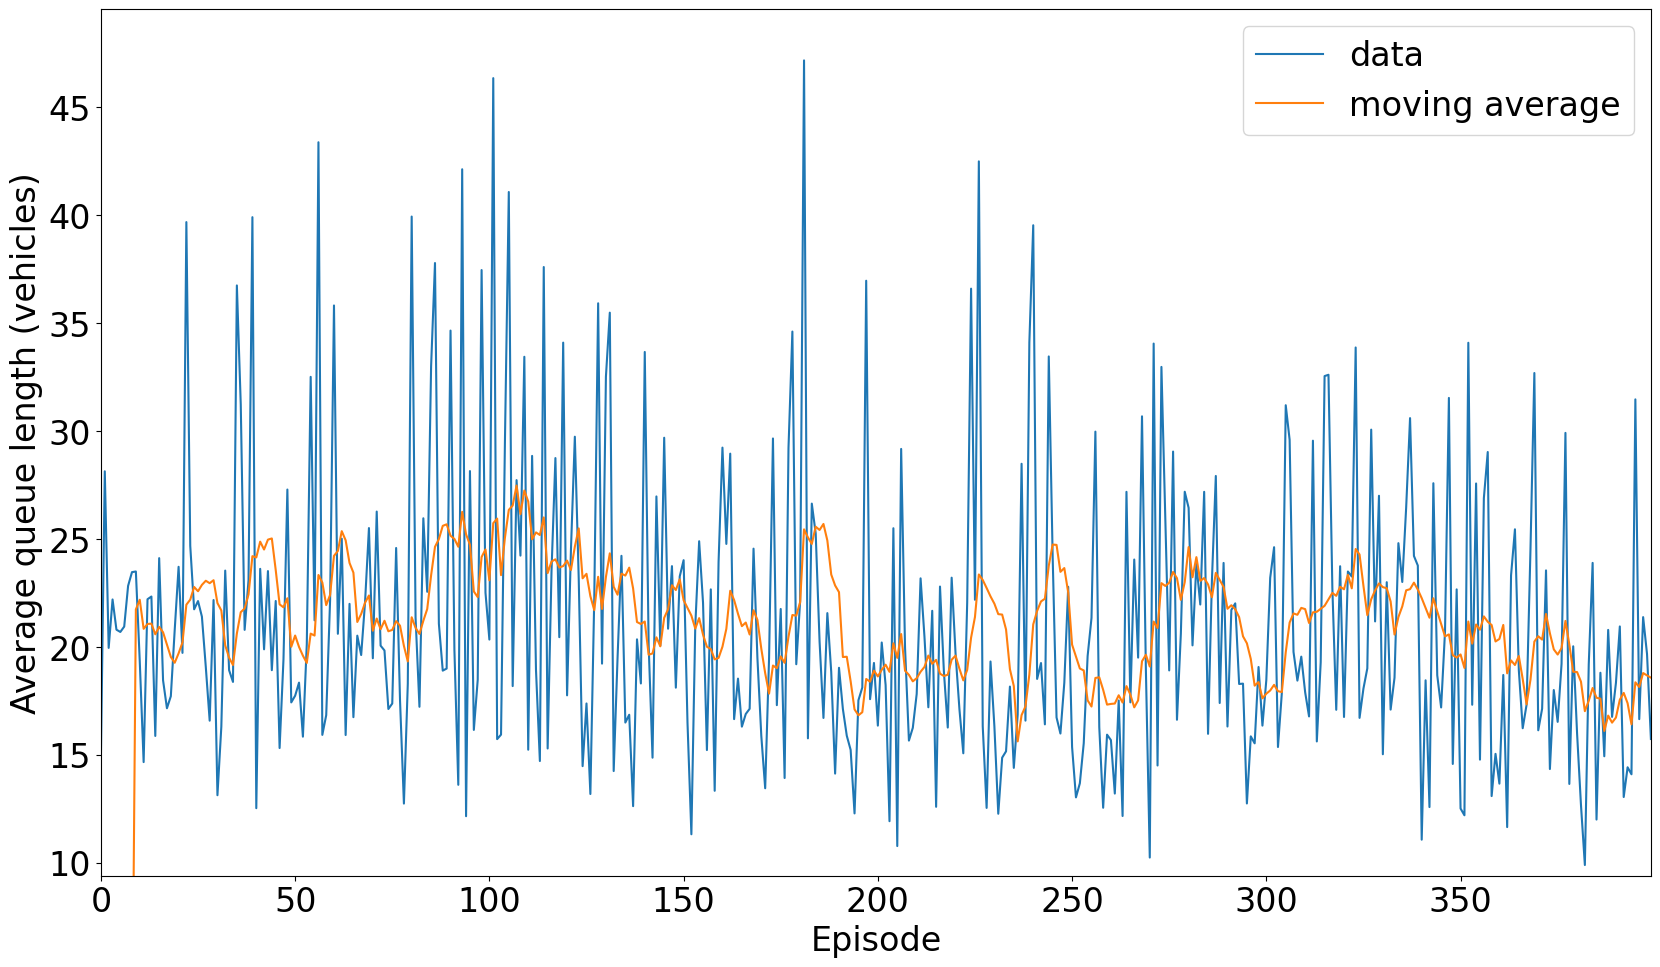

In [13]:
visualization.save_data_and_plot(data=simulation.avg_queue_length_store, filename='queue', xlabel='Episode', ylabel='Average queue length (vehicles)')

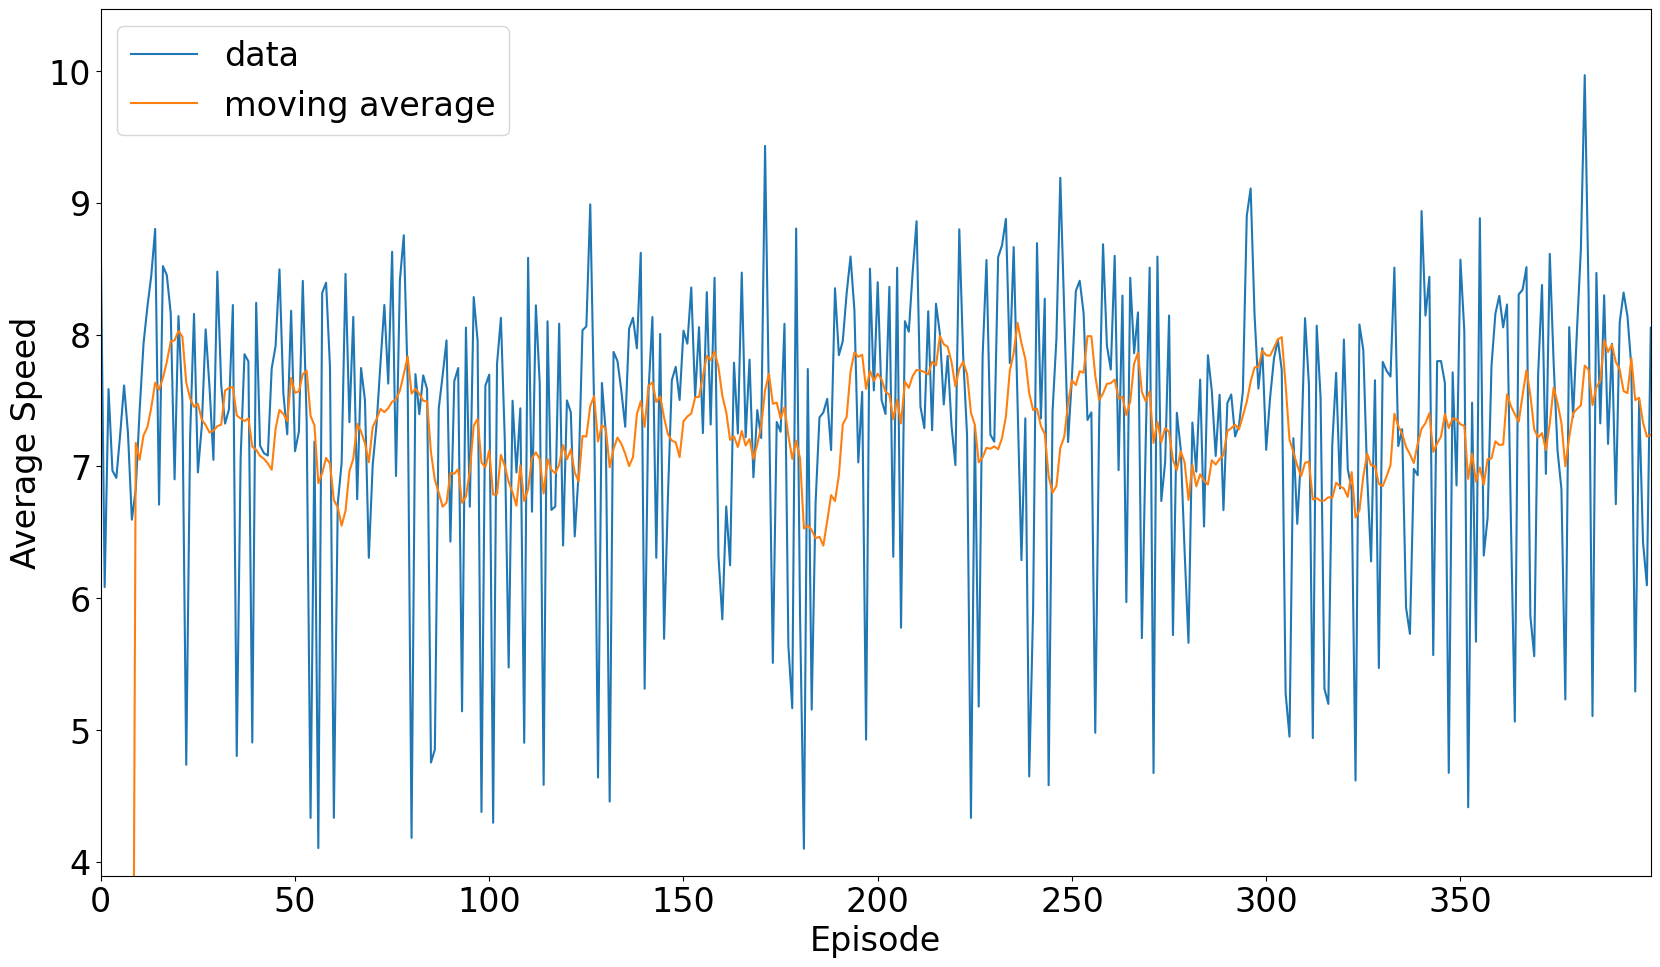

In [14]:
visualization.save_data_and_plot(data=simulation.speed_store, filename='Speed', xlabel='Episode', ylabel='Average Speed')

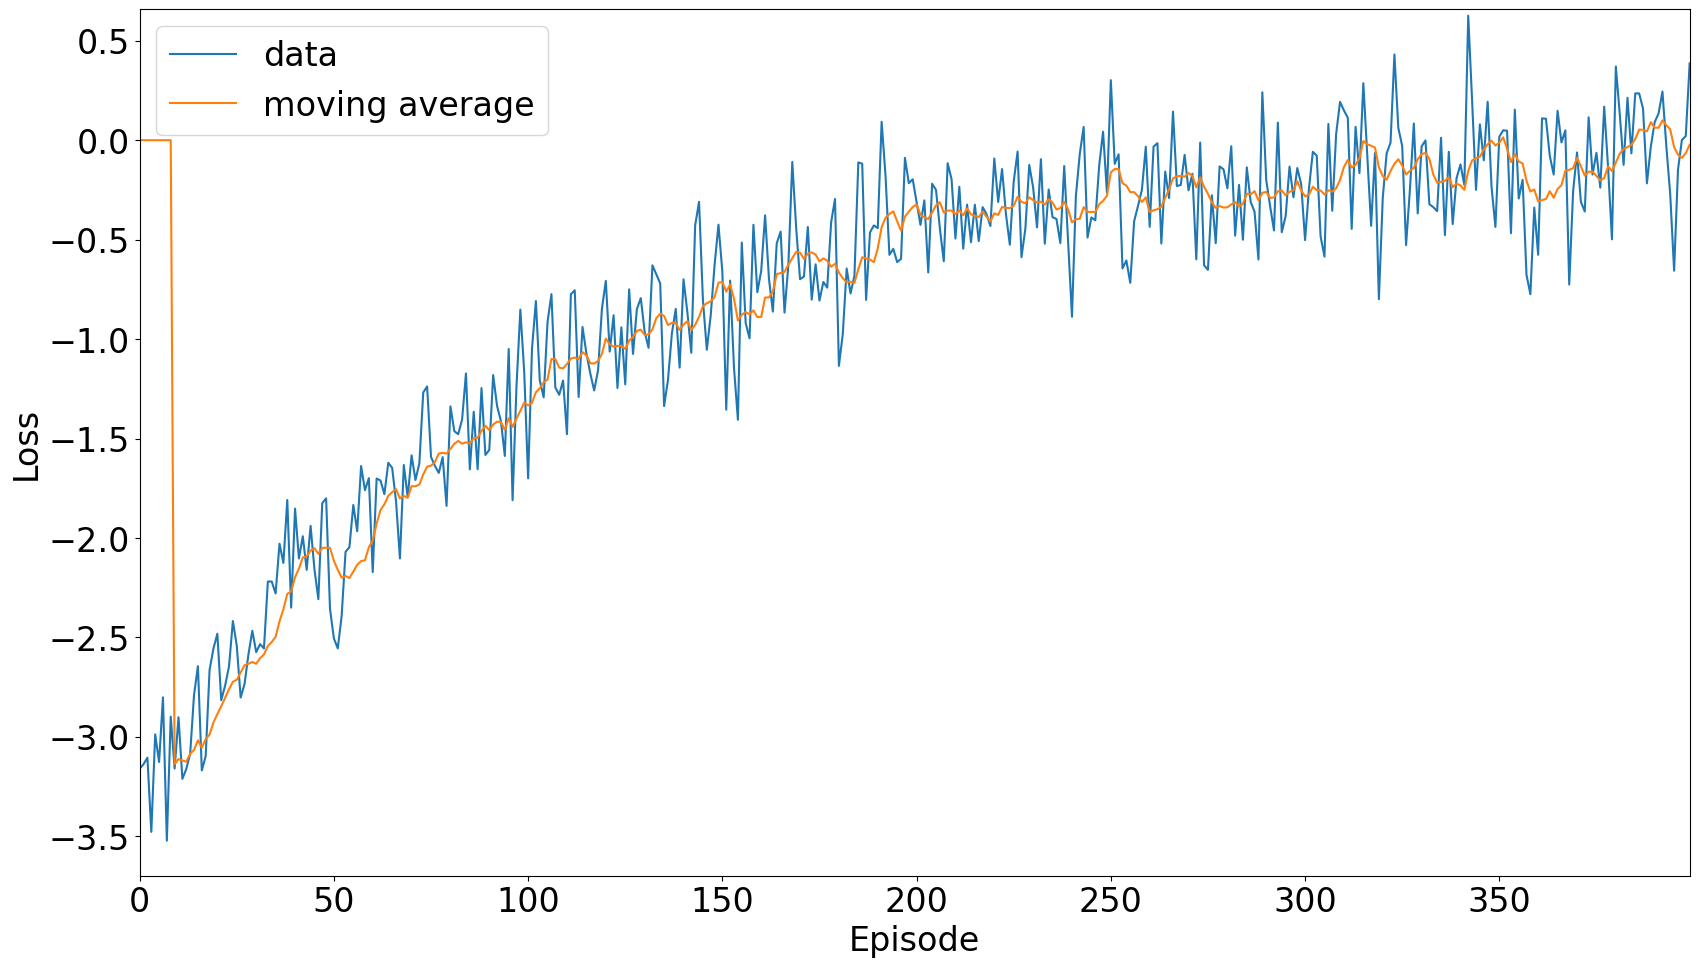

In [15]:
visualization.save_data_and_plot(data=[loss.cpu().detach() for loss in agent.actor_losses], filename='Actor_losses', xlabel='Episode', ylabel='Loss')

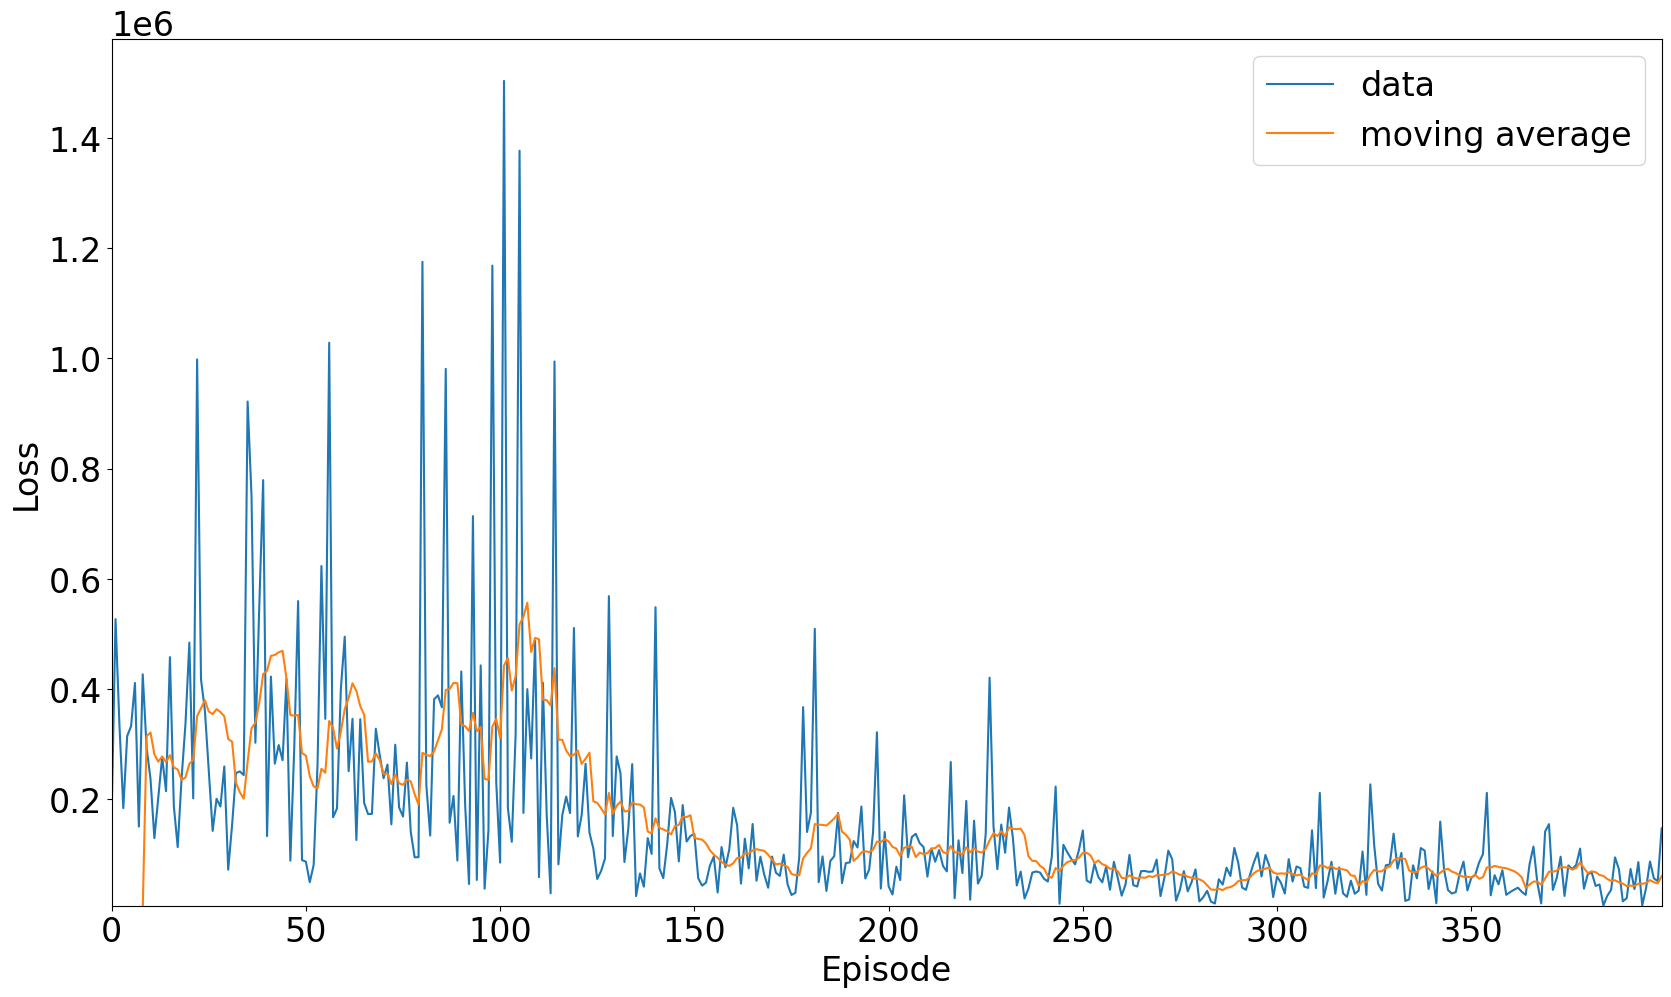

In [16]:
visualization.save_data_and_plot(data=[loss.cpu().detach() for loss in agent.critic_losses], filename='Critic_losses', xlabel='Episode', ylabel='Loss')

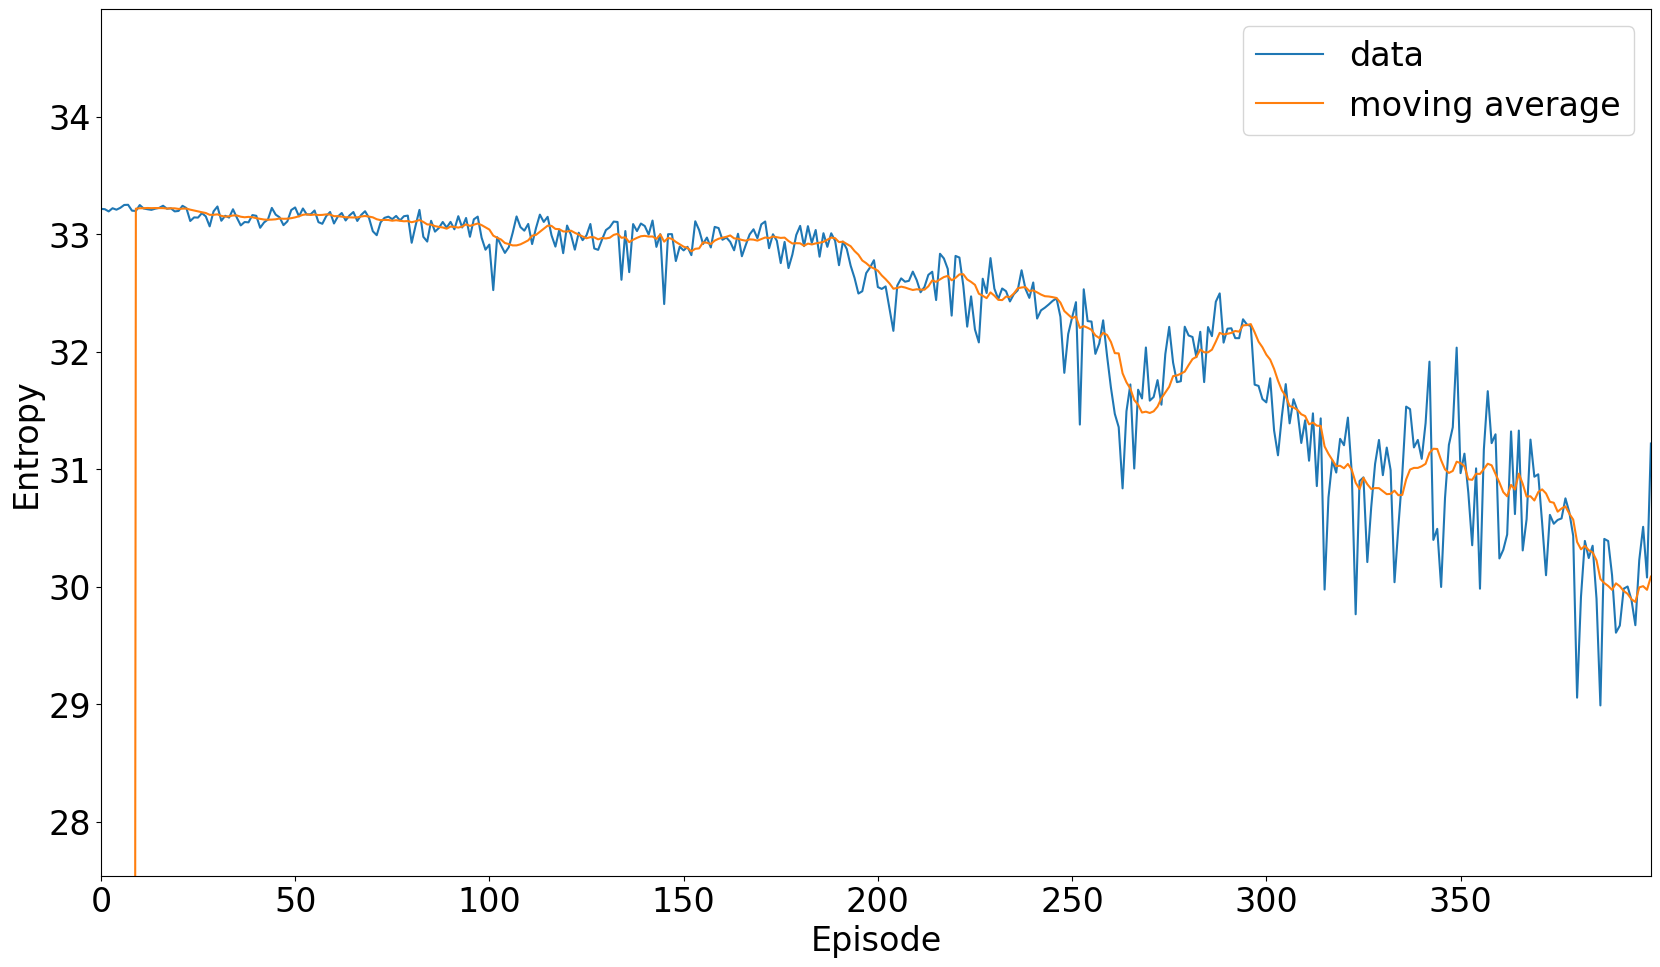

In [17]:
visualization.save_data_and_plot(data=[loss.cpu().detach() for loss in agent.entropies], filename='Critic_entropy', xlabel='Episode', ylabel='Entropy')

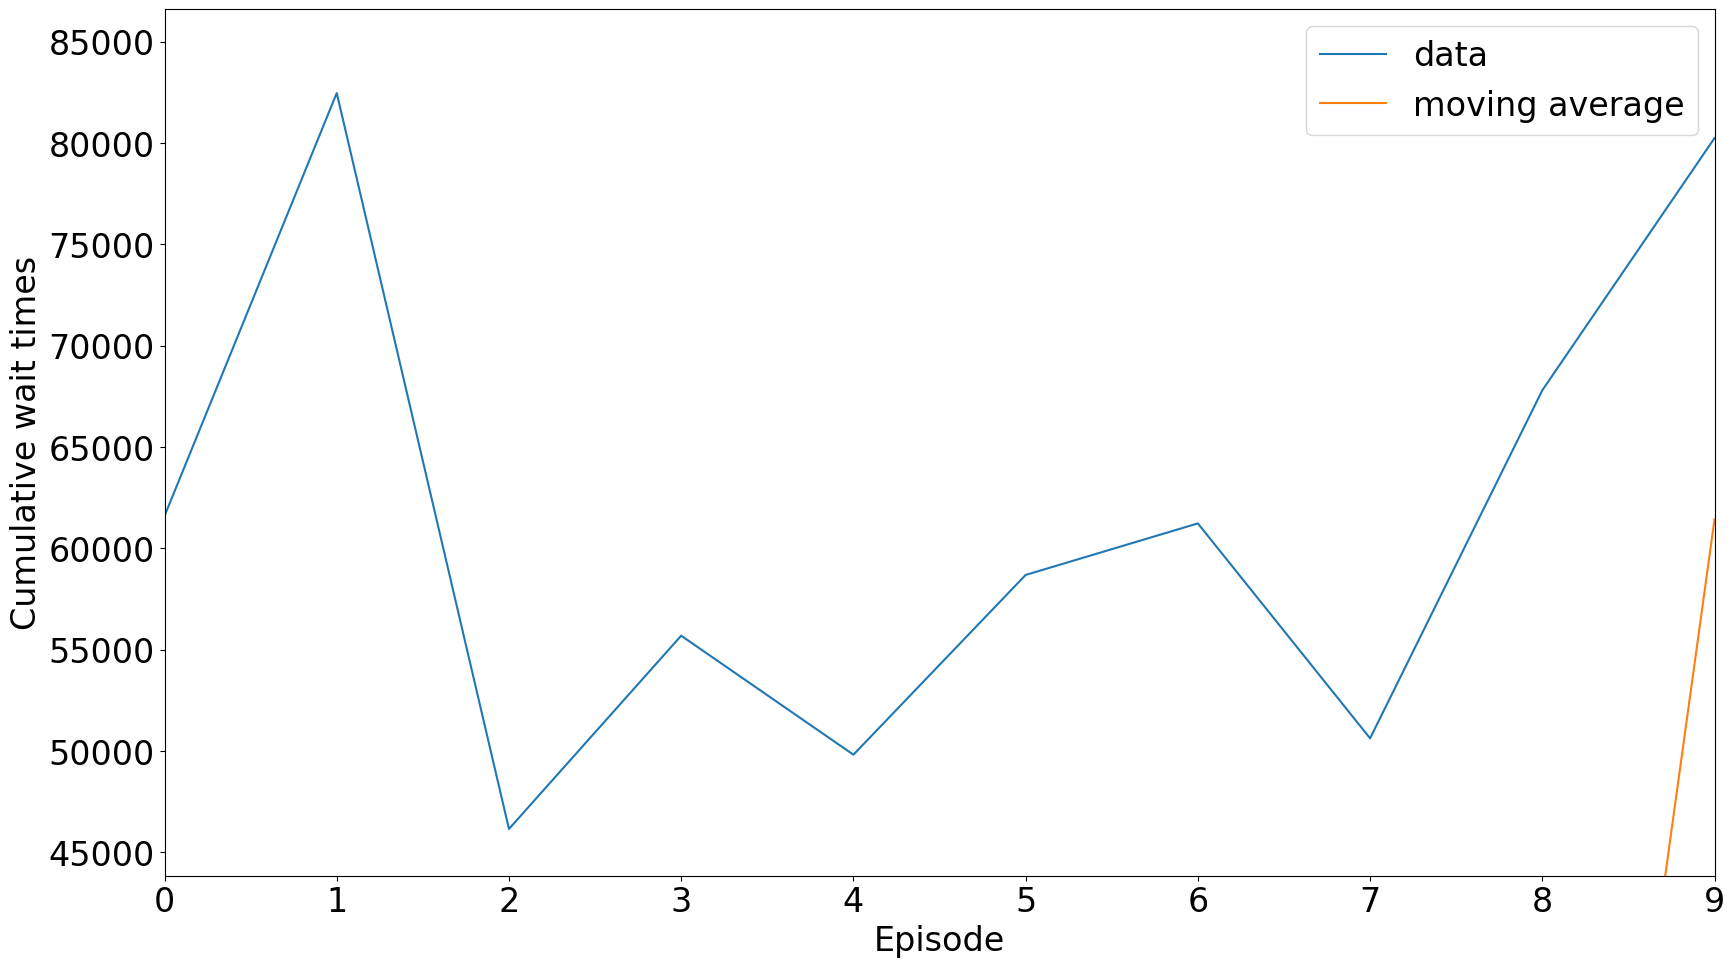

In [34]:
visualization.save_data_and_plot(data=evaluation.cumulative_wait_store, filename='wait_eva', xlabel='Episode', ylabel='Cumulative wait times')  

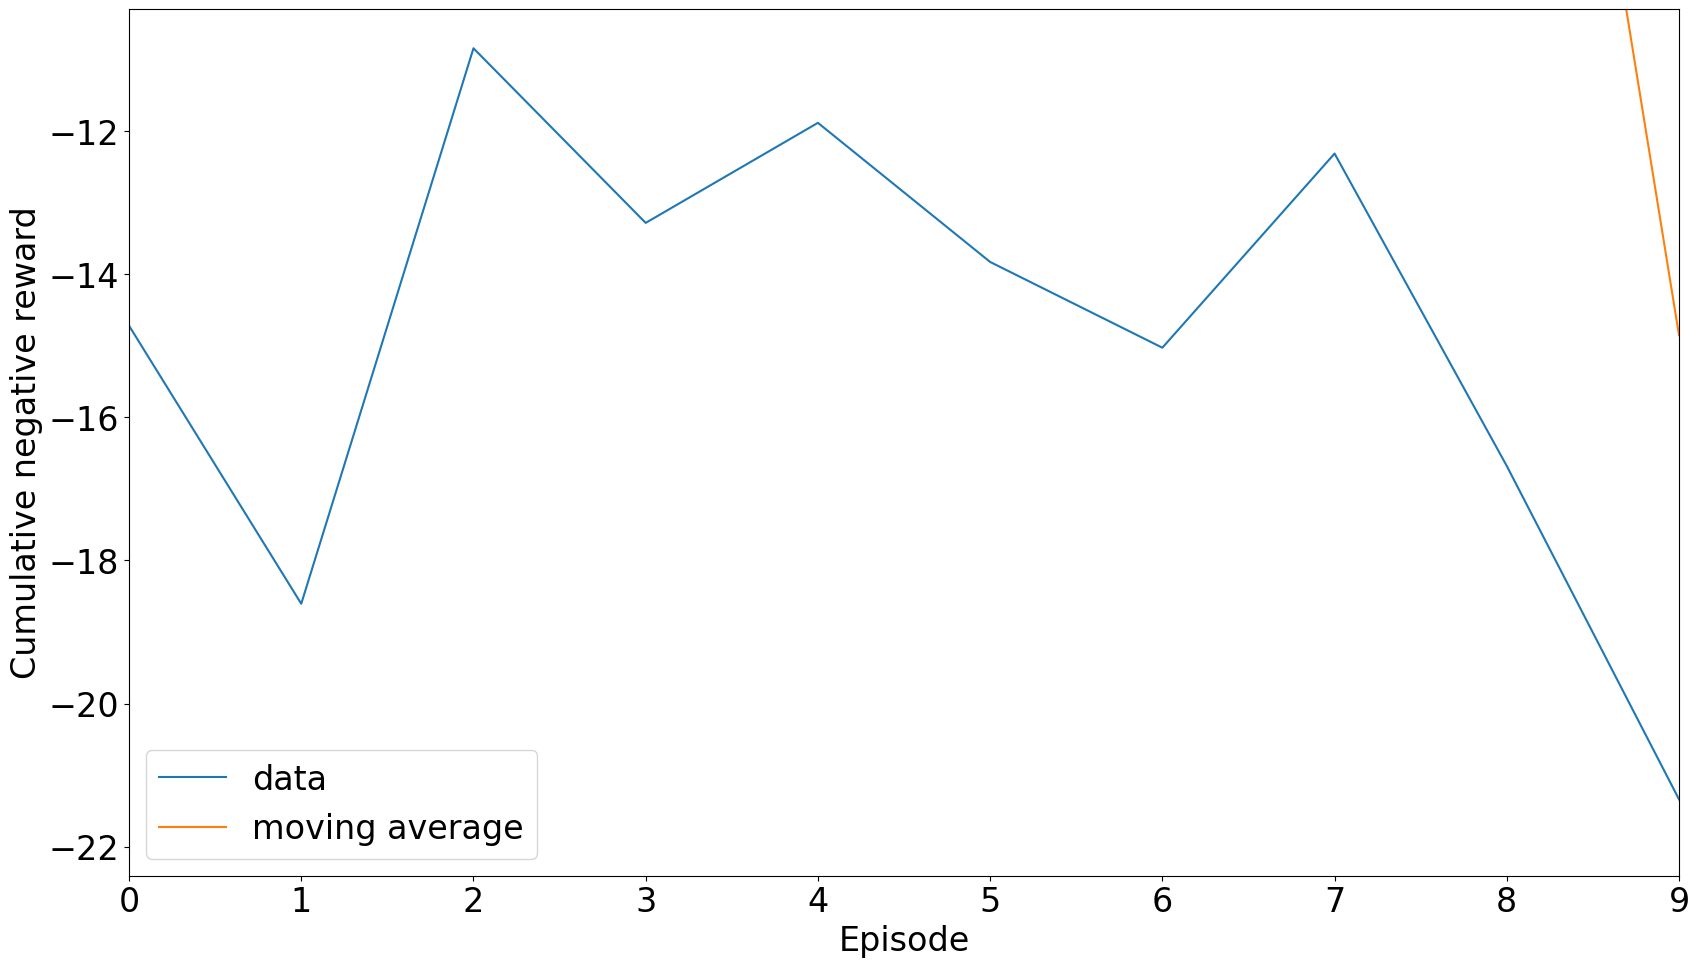

In [35]:
visualization.save_data_and_plot(data=evaluation.reward_store, filename='reward_eva', xlabel='Episode', ylabel='Cumulative negative reward')  

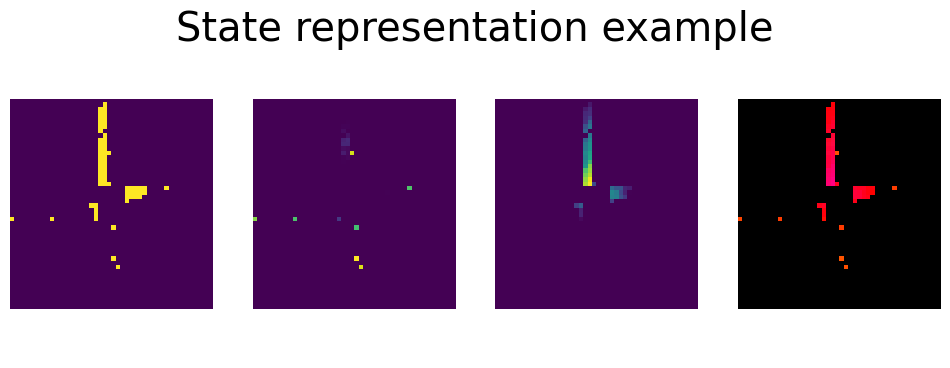

In [20]:
import matplotlib.pyplot as plt
idx = 80
state_img = agent.s_hoder[idx].transpose((1,2,0))

plt.figure(figsize=(12,4))
plt.title('State representation example')
plt.axis('off')
plt.subplot(141)
plt.imshow(state_img[:,:,0])
plt.axis('off')
plt.subplot(142)
plt.imshow(state_img[:,:,1])
plt.axis('off')
plt.subplot(143)
plt.imshow(state_img[:,:,2])
plt.axis('off')
plt.subplot(144)
plt.imshow(state_img)
plt.axis('off')
plt.show()
#val = agent.critic.forward(torch.from_numpy(agent.s_hoder[idx]).to(agent.dvc), )
#print(val)
#print(agent.val_hoder[idx])

In [25]:
n, h_out = agent.actor.forward(torch.from_numpy(agent.s_hoder[idx]).to(agent.dvc), (torch.from_numpy(agent.hin_hoder[idx,0,:]).view(1,1,-1).to(agent.dvc), torch.from_numpy(agent.hin_hoder[idx, 1, :]).view(1,1,-1).to(agent.dvc)))

h1_in, h2_in = torch.from_numpy(agent.hin_hoder[:, 0, :]), torch.from_numpy(agent.hin_hoder[:, 1, :])
first_hidden = (h1_in.view(1,256,-1).to(agent.dvc), h2_in.view(1,256,-1).to(agent.dvc))
h1_out, h2_out= torch.from_numpy(agent.hout_hoder[:, 0, :]), torch.from_numpy(agent.hout_hoder[:, 1, :])
second_hidden = (h1_out.view(1,256,-1).to(agent.dvc), h2_out.view(1,256,-1).to(agent.dvc))
a = torch.from_numpy(agent.a_hoder).to(agent.dvc)
old_prob_a = torch.from_numpy(agent.logprob_a_hoder).to(agent.dvc)

pi = F.softmax(agent.actor.l3(n), -1).view(-1, 8)

#pi, h_out = agent.actor.pi(, softmax_dim=0)
#print(agent.actor.l3(n).shape)
#print(pi) #F.softmax(self.l3(n, dim=softmax_dim)
m = Categorical(pi)
#print(m)
action = m.sample()
#pi_a = pi[0,action].item()
action_logprob = m.log_prob(action)
print(pi, action, action_logprob)

index = range(1,16)

n, h_out = agent.actor.forward(s[index], (first_hidden[0][:, index, :], first_hidden[1][:, index, :]))

pi = F.softmax(agent.actor.l3(n), -1).view(-1,8)
pi_sum = pi.sum(-1)
print("pi:", pi[0])
print("Sum of probabilities (should be 1):", pi_sum)
#print(pi.shape)
#print(F.softmax(agent.actor.l3(n), -1).squeeze(1).shape)
#print(Categorical(pi).entropy().sum(-1, keepdim=True))
entropy = Categorical(pi).entropy()
print("Entropy per batch element:", entropy)
# Sum entropy over batch
total_entropy = entropy.sum()
print("Total entropy:", total_entropy)
prob_a = pi.gather(1, a[index])
#print(Categorical(pi).entropy().sum(0, keepdim=True))
#print(pi.gather(1, a[index]))
ratio = torch.exp(torch.log(prob_a) - old_prob_a[index])
#print(ratio)
surr1 = ratio * adv[index]
#print(ratio)
#print(surr1)
surr2 = torch.clamp(ratio, 1 - agent.clip_rate, 1 + agent.clip_rate) * adv[index]
#print(surr1.shape, surr2.shape, entropy.shape)
#print(agent.entropy_coef * entropy.view(-1,1))
a_loss = -torch.min(surr1, surr2) - agent.entropy_coef * entropy.view(-1,1)
a_loss2 = -torch.min(surr1, surr2) - agent.entropy_coef * entropy
#print(a_loss.mean())
#print(a_loss2.mean())
#a_loss.mean().item(), a_loss2.mean().item()

tensor([[0.1256, 0.0954, 0.2298, 0.0360, 0.0487, 0.2051, 0.1705, 0.0890]],
       device='cuda:0', grad_fn=<ViewBackward0>) tensor([2], device='cuda:0') tensor([-1.4707], device='cuda:0', grad_fn=<SqueezeBackward1>)
pi: tensor([0.1511, 0.2314, 0.1154, 0.1707, 0.0716, 0.0960, 0.0823, 0.0816],
       device='cuda:0', grad_fn=<SelectBackward0>)
Sum of probabilities (should be 1): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)
Entropy per batch element: tensor([1.9988, 1.9969, 2.0107, 1.9683, 1.9949, 1.8142, 1.8800, 1.9183, 2.0000,
        1.9092, 2.0125, 1.9740, 1.9901, 1.9820, 1.9733], device='cuda:0',
       grad_fn=<NegBackward0>)
Total entropy: tensor(29.4233, device='cuda:0', grad_fn=<SumBackward0>)


In [91]:
agent.critic(s[index], (first_hidden[0][:, index, :], first_hidden[1][:, index, :])).view(-1,1),  td_target[index]

(tensor([[-1358.3157],
         [-1358.5970],
         [-1361.4937]], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[-1235.4027],
         [-1242.0543],
         [-1248.9742]], device='cuda:0'))

In [21]:
s = torch.from_numpy(agent.s_hoder).to(agent.dvc)
s_next = torch.from_numpy(agent.s_next_hoder).to(agent.dvc)
#vs = agent.critic(s)
#vs_ = agent.critic(s_next)
r = torch.from_numpy(agent.r_hoder).to(agent.dvc)
dw = torch.from_numpy(agent.dw_hoder).to(agent.dvc)
done = torch.from_numpy(agent.done_hoder).to(agent.dvc)

h1_in, h2_in = torch.from_numpy(agent.hin_hoder[:, 0, :]), torch.from_numpy(agent.hin_hoder[:, 1, :])
first_hidden = (h1_in.view(1,256,-1).to(agent.dvc), h2_in.view(1,256,-1).to(agent.dvc))
h1_out, h2_out= torch.from_numpy(agent.hout_hoder[:, 0, :]), torch.from_numpy(agent.hout_hoder[:, 1, :])
second_hidden = (h1_out.view(1,256,-1).to(agent.dvc), h2_out.view(1,256,-1).to(agent.dvc))

with torch.no_grad():
    vs = agent.critic(s, first_hidden).squeeze(1)
    vs_ = agent.critic(s_next, second_hidden).squeeze(1)
    '''GAE calculation'''
    deltas = r + agent.gamma*vs_*(~dw) - vs #self.gamma * vs_ * (~dw)
    deltas = deltas.cpu().flatten().numpy()            
    
    adv = [0]
    
    '''done for GAE'''
    for dlt, done in zip(deltas[::-1], done.cpu().flatten().numpy()[::-1]):
        advantage = dlt + agent.gamma * agent.lambd * adv[-1] * (~done)
        adv.append(advantage)
    adv.reverse()
adv = copy.deepcopy(adv[:-1])
adv = torch.tensor(adv).unsqueeze(1).float().to(agent.dvc)
print(adv.shape)
print(vs.shape)

td_target = adv + vs
adv = (adv - adv.mean()) / ((adv.std() + 1e-4))

torch.Size([256, 1])
torch.Size([256, 1])


In [20]:
print(vs.squeeze(1).shape)

torch.Size([256])


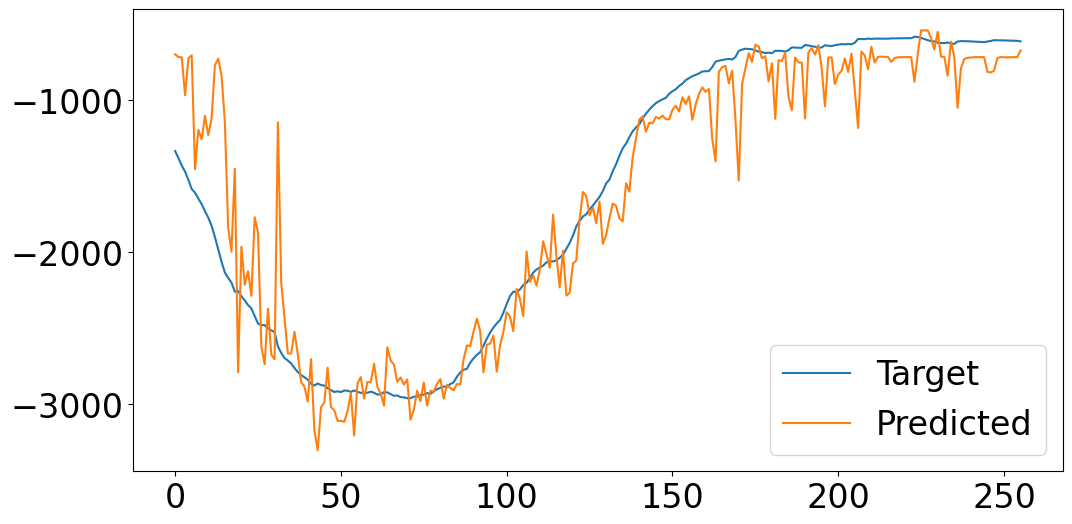

In [22]:
plt.figure(figsize=(12,6))
#plt.plot(vs.detach().cpu())
plt.plot(td_target.detach().cpu(), label='Target')
#print(td_target.shape)
plt.plot(vs.detach().cpu(), label= 'Predicted')
#plt.plot(r.detach().cpu(), label= 'Reward')
plt.legend()
plt.show()

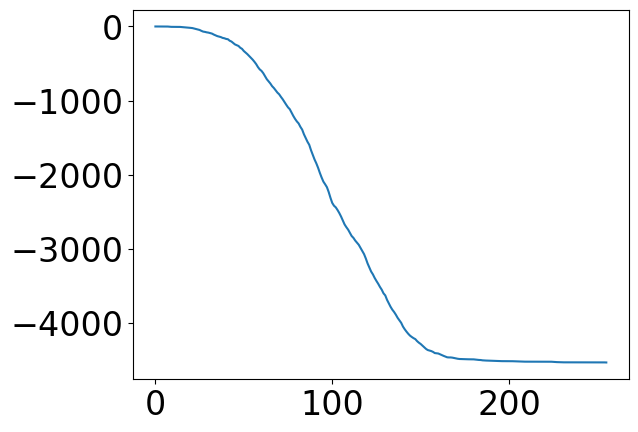

In [23]:
plt.plot(np.cumsum(r.detach().cpu()))